In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime as dt
import statsmodels.api as sm
import seaborn as sns
sns.set()

In [3]:
os_path = os.getcwd()
load_countries = pd.read_pickle(os.path.dirname(os_path)+'\\data\\load_countries.pkl')
load_countries.head()

,CZ,DE,GR,RO,RS
2015-01-01,6392.750000,45702.197917,6149.083333,NaN,NaN
2015-01-02,7137.625000,53704.781250,6428.250000,NaN,5743.625000
2015-01-03,6915.166667,50554.562500,6582.250000,NaN,5647.583333
2015-01-04,7048.708333,49079.000000,6207.041667,NaN,5495.708333
2015-01-05,8445.125000,59413.645833,6857.291667,7007.0,5790.125000


In [4]:
bg_data = pd.read_pickle(os.path.dirname(os_path)+'\\data\\energycons.pkl')
bg_data = bg_data['Load']
#aggregate to daily 
bg_data = bg_data.groupby(bg_data.index.strftime('%Y-%m-%d')).mean()
bg_data.index = pd.to_datetime(bg_data.index)
bg_data = bg_data[bg_data.index<'2021-01-01']

In [5]:
data_all = pd.concat([load_countries, bg_data], axis = 1)
data_all = data_all.rename(columns={"Load": "BG"})
data_all.head()

,CZ,DE,GR,RO,RS,BG
2015-01-01,6392.750000,45702.197917,6149.083333,NaN,NaN,4994.333333
2015-01-02,7137.625000,53704.781250,6428.250000,NaN,5743.625000,5249.416667
2015-01-03,6915.166667,50554.562500,6582.250000,NaN,5647.583333,5057.916667
2015-01-04,7048.708333,49079.000000,6207.041667,NaN,5495.708333,5230.083333
2015-01-05,8445.125000,59413.645833,6857.291667,7007.0,5790.125000,5596.916667


In [6]:
data_all = data_all.groupby(data_all.index.strftime('%Y-%m')).mean()
data_all.index = pd.to_datetime(data_all.index)
data_all.head()

,CZ,DE,GR,RO,RS,BG
2015-01-01,8095.599462,60545.105847,6455.241935,7428.544753,5477.825000,5285.120968
2015-02-01,8283.997024,62642.122768,6345.925595,7349.778274,5276.770833,5145.483631
2015-03-01,7777.343034,59623.960437,5987.865975,6880.487494,5118.671474,4693.877045
2015-04-01,7186.494444,55395.596181,5247.808333,6323.423611,4424.281944,4139.391667
2015-05-01,6714.288978,52745.733871,5158.120676,5863.989247,3782.883065,3598.479839


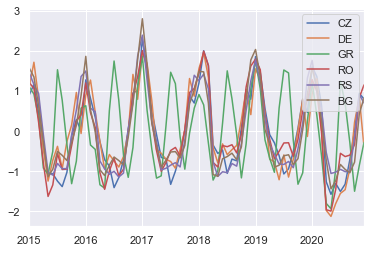

In [7]:
def plot_demeaned(df):
    data_all_demeaned = (df - df.mean())/df.std()
    
    return data_all_demeaned.plot();

plot_demeaned(data_all);

In [8]:
#seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
data_all_decomp = data_all.copy()

for each_col in data_all.columns:
    results_additive = seasonal_decompose(data_all[each_col], model='additive', period = 12)
    decomp_series = data_all_decomp[each_col] - results_additive.seasonal
    data_all_decomp[each_col] = decomp_series


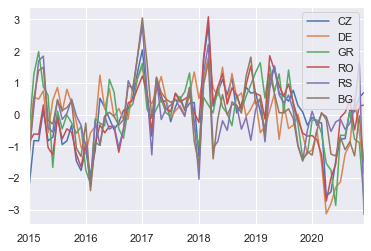

In [9]:
plot_demeaned(data_all_decomp);

In [10]:
data_all_decomp = np.log(data_all_decomp)

In [11]:
from statsmodels.tsa.api import VAR
model = VAR(data_all_decomp.dropna())

C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [13]:
results = model.fit(maxlags = 5, ic = 'bic')

In [14]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Feb, 2021
Time:                     10:45:02
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -45.8653
Nobs:                     71.0000    HQIC:                  -46.6715
Log likelihood:           1113.27    FPE:                3.17190e-21
AIC:                     -47.2038    Det(Omega_mle):     1.80427e-21
--------------------------------------------------------------------
Results for equation CZ
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         2.318211         1.406326            1.648           0.099
L1.CZ         0.081402         0.211467            0.385           0.700
L1.DE         0.204274         0.166614            1.226           0.220
L1.GR         0.104231

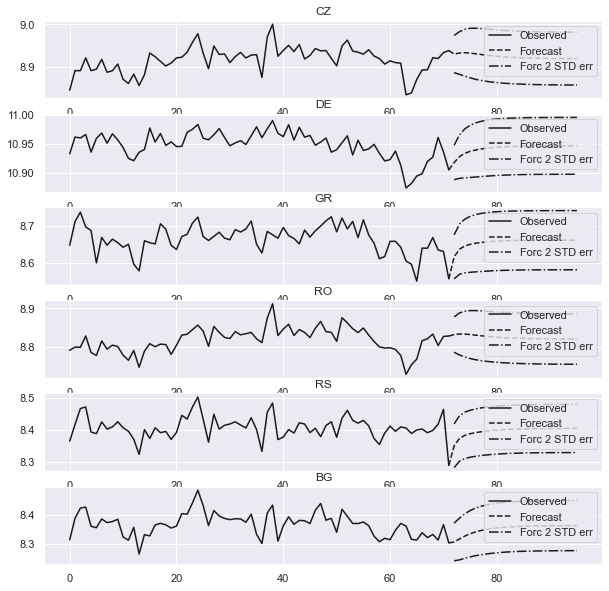

In [15]:
results.plot_forecast(steps = 24);

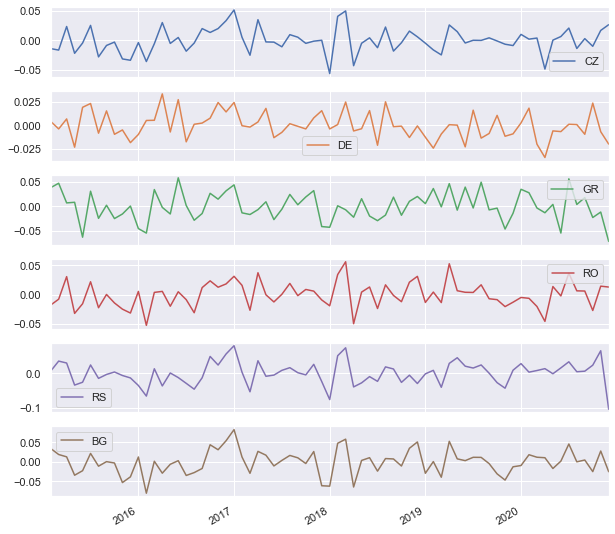

In [16]:
results.resid.plot(subplots=True, figsize=(10,10));